In [108]:
import sys; sys.path.append("../")

import os
import sys
import pickle
from model import *
from SALib.sample import sobol, saltelli
from tqdm import tqdm


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
USE_TEX = False
if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [25]:
N = 100
mu = 10
sigma = 1
w = np.random.normal(mu, sigma, N)

In [82]:
G = construct_sda_graph(w, alpha=4, b=1/15)

In [83]:
# construct communities and augmented communities
communities = get_communities(G)
community_membership = get_community_membership(G, communities)

augmented_communities = {}
for agent in community_membership:
    comms = community_membership[agent]
    for c in comms:
        if c not in augmented_communities:
            augmented_communities[c] = {agent}
        else:
            augmented_communities[c].add(agent) 
augmented_communities = {k:np.array(list(v)) for k,v in augmented_communities.items()}
del augmented_communities[max(augmented_communities.keys())]

In [84]:
# get community adjacency matrix and degree distribution
adjacency = dict((n, set(nbrdict.keys())) for n, nbrdict in G.adjacency())
node_community_map = get_node_community_map(communities)

community_adjacency = {}
for i,c in enumerate(communities):
    community_adjacency[i] = set()
    for node in c:
        node_neighbours = adjacency[node]
        for neighbour in node_neighbours:
            neighbouring_community = node_community_map[neighbour]
            if neighbouring_community != i:
                community_adjacency[i].add(neighbouring_community)
comm_degrees = [len(x) for x in list(community_adjacency.values())]

16

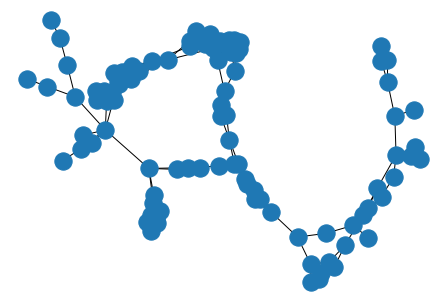

In [91]:
nx.draw(G)
len(augmented_communities)

1.1172690481876424 1.893694202638671 1.438117549152565
1.1269510509067269 3.072568650189164 1.8691904948351468
1.1328098889311269 4.502165025703598 2.371666241720022
1.1211245464376478 5.887815268111923 2.8643691778146154


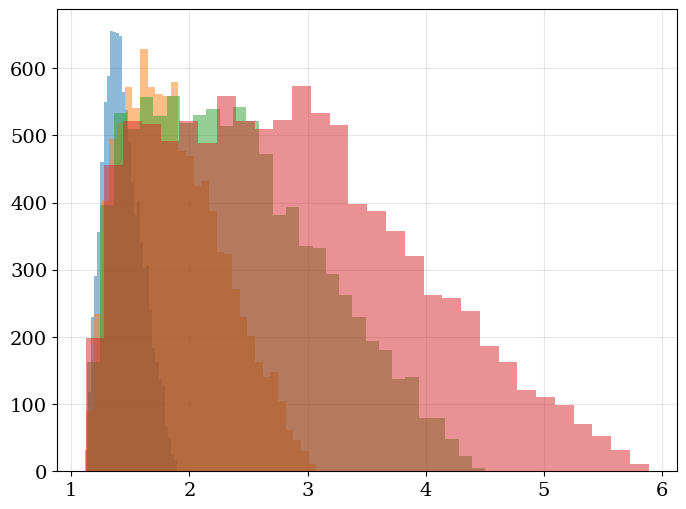

In [138]:
for r in [2.3, 4, 6, 8]:


    gambles = generate_gambles(10000, r, 0.30)

    gamble_prior_samples = np.zeros((5000, len(gambles)))
    for i,g in enumerate(gambles):
        gamble_prior_samples[:,i] = np.random.choice(g["outcomes"], 5000, p=g["probs"])
    gambles_prior_mu  = np.mean(gamble_prior_samples, axis=0)

    plt.hist(gambles_prior_mu, bins=30, alpha=0.5)
    assert min(gambles_prior_mu) >= 1.1
    print(min(gambles_prior_mu), max(gambles_prior_mu), np.mean(gambles_prior_mu))

plt.show()